### Study initial dataset

In [1]:
import os
from pathlib import Path
from pymatgen.io.cif import CifWriter
from mp_api.client import MPRester
import pandas as pd
import numpy as np
from matplotlib_venn import venn2

# conda env config vars set MP_API_KEY=your_key
api_key = os.environ.get("MP_API_KEY")

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fcd8e206610>>
Traceback (most recent call last):
  File "/home/nodoteve/apps/pythom/miniconda/envs/cgcnn/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [2]:
# read ids
ids = pd.read_csv("./data/material-data/mp-ids-46744.csv")
ids = [list(ids)[0]] + list(ids.iloc[:, 0])
print(len(ids))

46744


In [3]:
# my venn diagram for two sets
def venn(**kvarg):
    subsets = []
    set_labels = []
    for k, v in kvarg.items():
        subsets.append(set(v))
        set_labels.append(k)
    venn2(subsets=subsets, set_labels=set_labels)


# get duplicates set of duplicates
def get_duplicates_list(a: list):
    h = dict()
    for x in a:
        h.setdefault(x, 0)
        h[x] += 1
    repeated = list()
    for k, v in h.items():
        if v > 1:
            repeated += [k for i in range(1, v)]
    return repeated


def get_duplicates_set(a: list):
    return set(get_duplicates_list(a))

In [4]:
# with MPRester(api_key) as mpr:
#     naive_docs = mpr.materials.search(material_ids=ids, fields=['material_id'])
# ValueError: List of material/molecule IDs provided is too long. Consider removing the ID filter to automatically pull data for all IDs and filter locally.
# fix via chunk loading with const:
# 10000

from emmet.core.vasp.material import MaterialsDoc


def chunked_load_ids(kind_of_ids: str, **kwargs) -> list[MaterialsDoc]:
    """kwargs[kind_of_ids] is divided into chunks"""
    if kind_of_ids not in kwargs:
        return []
    chunk_size = 10000
    docs = []
    with MPRester(api_key) as mpr:
        ids = kwargs[kind_of_ids]
        kwargs.pop(kind_of_ids)
        for k in range(0, len(ids), chunk_size):
            chunk = [
                doc
                for doc in mpr.materials.search(
                    **dict([(kind_of_ids, ids[k : k + chunk_size])]), **kwargs
                )
            ]
            docs += chunk
    return docs

#### Naive approach

In [15]:
docs_naive = chunked_load_ids("material_ids", material_ids=ids, fields=["material_id"])
depr_docs_naive = chunked_load_ids(
    "material_ids", material_ids=ids, fields=["material_id"], deprecated=True
)

NameError: name 'ids' is not defined

In [ ]:
material_ids_naive = [str(doc.material_id) for doc in docs_naive]
material_ids_duplicates_naive = get_duplicates_set(material_ids_naive)

depr_material_ids_naive = [str(doc.material_id) for doc in depr_docs_naive]
depr_material_ids_duplicates_naive = get_duplicates_set(depr_material_ids_naive)

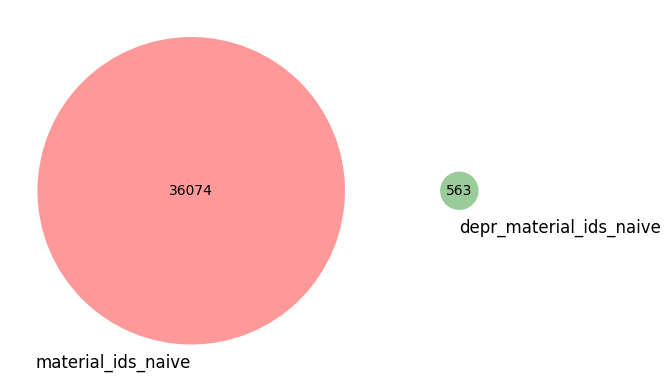

In [ ]:
venn(
    material_ids_naive=material_ids_naive,
    depr_material_ids_naive=depr_material_ids_naive,
)

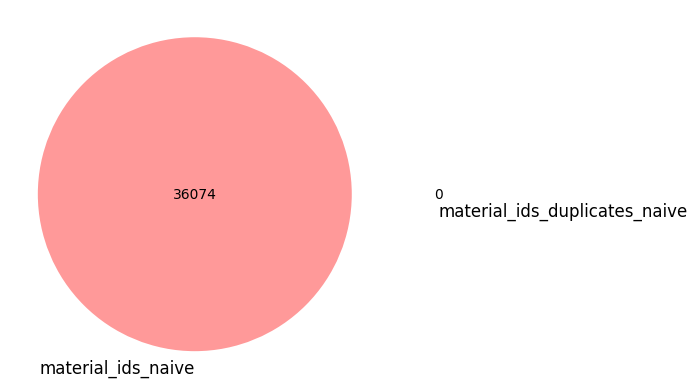

In [ ]:
venn(
    material_ids_naive=material_ids_naive,
    material_ids_duplicates_naive=material_ids_duplicates_naive,
)

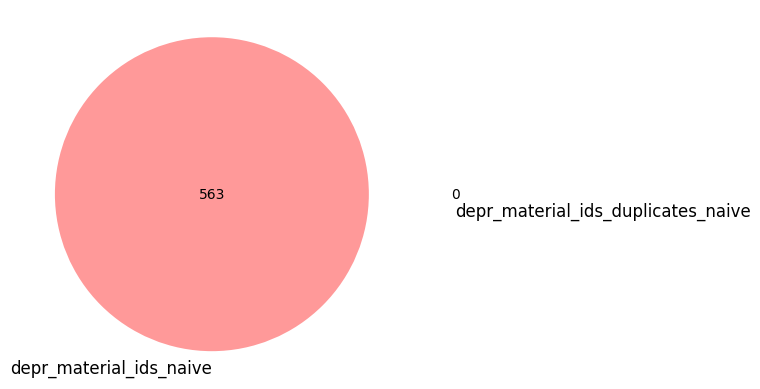

In [ ]:
venn(
    depr_material_ids_naive=depr_material_ids_naive,
    depr_material_ids_duplicates_naive=depr_material_ids_duplicates_naive,
)

#### Different approach

Taking into consideration that listed ids are task ids.

In [ ]:
docs = chunked_load_ids("task_ids", task_ids=ids, fields=["material_id"])
depr_docs = chunked_load_ids(
    "task_ids", task_ids=ids, fields=["material_id"], deprecated=True
)

/home/nodoteve/apps/pythom/miniconda/envs/cgcnn2/lib/python3.11/site-packages/mp_api/client/mprester.py:227: UserWarning: mpcontribs-client not installed. Install the package to query MPContribs data, or construct pourbaix diagrams: 'pip install mpcontribs-client'
  warnings.warn(


Retrieving MaterialsDoc documents:   0%|          | 0/9872 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/9868 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/9870 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/9885 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/6668 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/128 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/132 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/130 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/115 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/76 [00:00<?, ?it/s]

In [ ]:
material_ids = [str(d.material_id) for d in docs]
material_ids_duplicates = get_duplicates_set(material_ids)

depr_material_ids = [str(d.material_id) for d in depr_docs]
depr_material_ids_duplicates = get_duplicates_set(depr_material_ids)

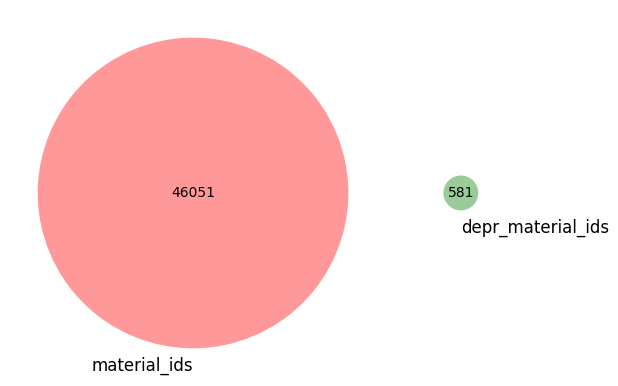

In [ ]:
venn(material_ids=material_ids, depr_material_ids=depr_material_ids)

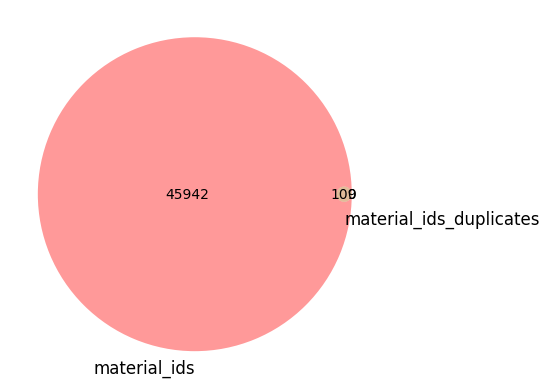

In [ ]:
venn(material_ids=material_ids, material_ids_duplicates=material_ids_duplicates)

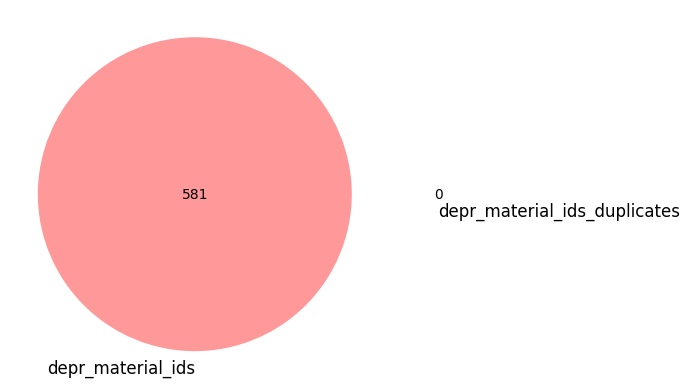

In [ ]:
venn(
    depr_material_ids=depr_material_ids,
    depr_material_ids_duplicates=depr_material_ids_duplicates,
)

Knowing the complete set of material_ids it is possible to create a map between task_ids and material_ids

In [ ]:
all_mids = list(set(material_ids).union(set(depr_material_ids)))
docs_for_t2m = chunked_load_ids(
    "material_ids", material_ids=all_mids, fields=["material_id", "task_ids"]
)
depr_docs_for_t2m = chunked_load_ids(
    "material_ids",
    material_ids=all_mids,
    fields=["material_id", "task_ids"],
    deprecated=True,
)

Retrieving MaterialsDoc documents:   0%|          | 0/9880 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/9881 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/9868 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/9882 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/6540 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/120 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/119 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/132 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/118 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/92 [00:00<?, ?it/s]

In [ ]:
mids = [str(d.material_id) for d in docs_for_t2m]
depr_mids = [str(d.material_id) for d in depr_docs_for_t2m]

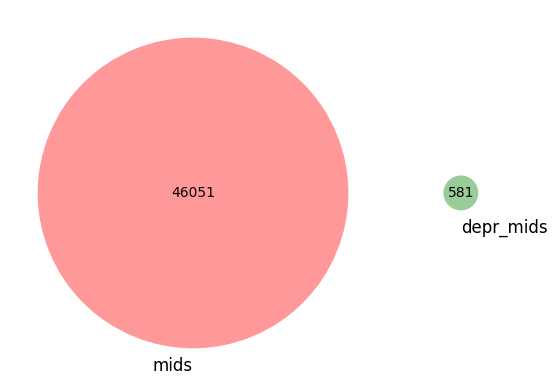

In [ ]:
venn(mids=mids, depr_mids=depr_mids)
# No venn intersection => mids are unique

In [ ]:
mt_ids = [(str(d.material_id), [str(x) for x in d.task_ids]) for d in docs_for_t2m]
depr_mt_ids = [
    (str(d.material_id), [str(x) for x in d.task_ids]) for d in depr_docs_for_t2m
]

# keep only task_ids from (initial) ids.
sids = set(ids)
redused_mt_ids = [(m, [x for x in t if x in sids]) for m, t in mt_ids]
redused_depr_mt_ids = [(m, [x for x in t if x in sids]) for m, t in depr_mt_ids]

# flatten
all_tids = []
for m, t in redused_mt_ids:
    all_tids += t
for m, t in redused_depr_mt_ids:
    all_tids += t
print(len(get_duplicates_set(all_tids)))

0


Correspondence between tids and mids strictly obeys the law that there is only one mid for the given tid.

In [ ]:
# create map task_id -> material_id
t2m = dict()
for m, t in mt_ids:
    for x in t:
        t2m[x] = m
for m, t in depr_mt_ids:
    for x in t:
        t2m[x] = m
found = [x for x in ids if x in t2m]
not_found = [x for x in ids if x not in t2m]

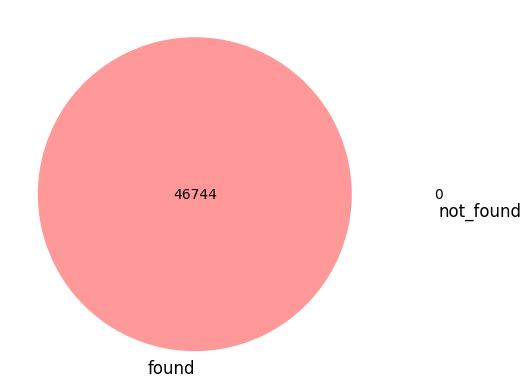

In [ ]:
# compare with (initial) ids
venn(found=found, not_found=not_found)

In [ ]:
# set theoretical image of ids after t2m
img = [t2m[x] for x in ids]

46632 + 112 = 46744


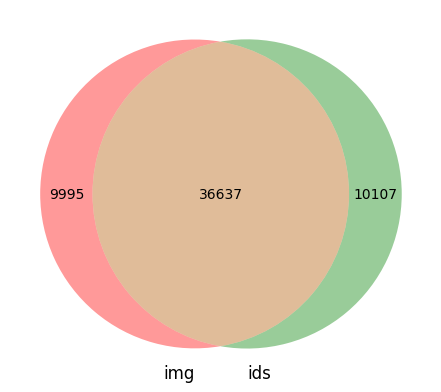

In [ ]:
print(len(set(img)), "+", len(get_duplicates_list(img)), "=", len(ids))
venn(img=img, ids=ids)
# => Actual number of duplicates (data leak) in article implementation could be around the value of get_duplicates_list(img))
# or 100 ids out of 46744 (~0.2%)
# (~800 and 1.8% in previous version of db)

### Dataset creation
Creating datasets based on material project ids. Then checking the difference in training results.

#### Load data

##### From Materials Project

In [5]:
# dataset saving paths
basedir = "./data/root/data/"
t2m_file = "./data/root/data/t2m.json"


def save_to_bin(data: dict, output_file):
    import ormsgpack

    with open(output_file, "wb") as f:
        f.write(ormsgpack.packb(data, option=ormsgpack.OPT_SERIALIZE_NUMPY))


def load_from_bin(file):
    with open(file, "rb") as f:
        import ormsgpack

        return ormsgpack.unpackb(f.read())


def save_to_json(data: dict, output_file):
    import orjson

    with open(output_file, "wb") as f:
        f.write(orjson.dumps(data, option=orjson.OPT_SERIALIZE_NUMPY))


def load_from_json(file):
    with open(file, "rb") as f:
        import orjson

        return orjson.loads(f.read())

In [6]:
def chunked_load_data(kind_of_ids: str, **kwargs) -> list[MaterialsDoc]:
    """kwargs[kind_of_ids] is divided into chunks
    differs from chunked_load_ids():
        mpr.materials.search
        ->
        mpr.materials.summary.search"""
    if kind_of_ids not in kwargs:
        return []
    chunk_size = 10000
    docs = []
    with MPRester(api_key) as mpr:
        ids = kwargs[kind_of_ids]
        kwargs.pop(kind_of_ids)
        for k in range(0, len(ids), chunk_size):
            chunk = [
                doc
                for doc in mpr.materials.summary.search(
                    **dict([(kind_of_ids, ids[k : k + chunk_size])]), **kwargs
                )
            ]
            docs += chunk
    return docs

In [7]:
from datetime import date

# downloading functionality
fields = [
    "energy_per_atom",
    "formation_energy_per_atom",
    "band_gap",
    "efermi",
    "shear_modulus",  # "k_voigt", "k_reuss", "k_vrh", see https://docs.materialsproject.org/methodology/materials-methodology/elasticity/
    "bulk_modulus",  # "g_voigt","g_reuss", "g_vrh"
    "homogeneous_poisson",
]


def download_by_material_ids(mids) -> list[MaterialsDoc]:
    docs = chunked_load_data(
        "material_ids",
        material_ids=mids,
        fields=fields + ["structure", "material_id"],
    )
    depr_docs = chunked_load_data(
        "material_ids",
        material_ids=mids,
        fields=fields + ["structure", "material_id"],
        deprecated=True,
    )
    all_docs = depr_docs + docs
    return all_docs


def save_docs_as_json(docs: list[MaterialsDoc], dataset_dir: str):
    props = dict()
    cifs = dict()
    for doc in docs:
        mid = str(doc.material_id)
        # structures
        cifs[mid] = doc.structure.as_dict()

        # properties
        dump = doc.model_dump(include=fields)

        # translate shear_modulus and bulk_modulus to k_ and g_ in case they exist
        # example:
        #   dump["shear_modulus"]["vrh"] -> dump["k_vrh"]
        modulus_types = ["voigt", "reuss", "vrh"]
        key_map = {"shear_modulus": "k_", "bulk_modulus": "g_"}
        for k, v in key_map.items():
            if k in dump:
                if dump[k] is not None:
                    for t in modulus_types:
                        dump[v + t] = dump[k][t]
                        dump[k].pop(t)
                dump.pop(k)
        # training of these properties is performed in log scale
        for moduli in ["k_voigt", "k_reuss", "k_vrh", "g_voigt", "g_reuss", "g_vrh"]:
            if moduli in dump:
                dump[moduli] = np.log(dump[moduli])
        props[mid] = dump

    try:
        os.mkdir(dataset_dir)
    except:
        pass
    save_to_json(cifs, dataset_dir + "cifs.json")
    save_to_json(props, dataset_dir + "props.json")
    return dataset_dir

Download might take some time

In [8]:
# create dataset based on material ids from original paper
dataset_original_path = basedir + "dataset_original_" + date.today().isoformat() + "/"


# docs = []
def create_original():
    img = [t2m[x] for x in ids]
    docs = download_by_material_ids(mids=img)
    save_docs_as_json(docs, dataset_original_path)
    return [str(doc.material_id) for doc in docs]


# ~ 7 min

In [9]:
# ids1 = create_original()
# df1 = pd.DataFrame(load_from_json(dataset_original_path + "props.json")).transpose()
# print(df1.describe())

In [10]:
# create dataset from all materials available at Materials Project currently
dataset_full_path = basedir + "dataset_full_" + date.today().isoformat() + "/"


def create_full():
    def download_full_mpdb_undeprecated():
        with MPRester(api_key) as mpr:
            docs = [
                d
                for d in mpr.materials.summary.search(
                    fields=fields + ["structure", "material_id"],
                )
            ]
            return docs

    docs = download_full_mpdb_undeprecated()
    save_docs_as_json(docs, dataset_full_path)
    return [str(doc.material_id) for doc in docs]


# ~ 15 min

In [11]:
# ids2 = create_full()

In [12]:
# create delta dataset as a set difference of previous two
dataset_delta_path = basedir + "dataset_delta/"


def create_delta(ids1, ids2, dataset_full_path):
    ids_delta = set(ids2).difference(set(ids1))
    props_full = load_from_json(dataset_full_path + "props.json")
    props_delta = dict()
    for k, v in props_full.items():
        if k in ids_delta:
            props_delta[k] = v
    cifs_full = load_from_json(dataset_full_path + "cifs.json")
    cifs_delta = dict()
    for k, v in cifs_full.items():
        if k in ids_delta:
            cifs_delta[k] = v
    try:
        os.mkdir(dataset_delta_path)
    except:
        pass
    save_to_json(cifs_delta, dataset_delta_path + "cifs.json")
    save_to_json(props_delta, dataset_delta_path + "props.json")

In [13]:
# some thermodynamic properties of Materials Project significantly changed recently due to migration from GGA/GGA+U to r2SCAN
dataset_original_before_r2scan_path = basedir + "dataset_original_before_r2scan/"
dataset_full_before_r2scan_path = (
    basedir + "dataset_full_before_r2scan/"
)  # does not contain shear/bulk modulus

dataset_original_path = basedir + "dataset_original_2024-04-25/"
dataset_full_path = basedir + "dataset_full_2024-04-25/"
dataset_delta_path = basedir + "dataset_delta/"

In [14]:
dataset_paths = [
    dataset_original_path,
    dataset_full_path,
    dataset_delta_path,
    dataset_original_before_r2scan_path,
    dataset_full_before_r2scan_path,
]

##### From QMOF

In [15]:
# expected to have qmof_database.zip archive downloaded from Figshare https://docs.materialsproject.org/apps/explorer-apps/mof-explorer/downloading-the-data
qmof_db_path = basedir + "qmof_db/"

##### Compression

In [16]:
import zstandard as zstd


def compress(from_file, to_file):
    with open(from_file, "rb") as f:
        res = zstd.ZstdCompressor(level=15, threads=-1).compress(f.read())
    with open(to_file, "wb") as f:
        f.write(res)


def uncompress(from_file, to_file):
    with open(from_file, "rb") as f:
        res = zstd.decompress(f.read())
    with open(to_file, "wb") as f:
        f.write(res)


def compress_inplace(dataset_path):
    filenames = os.listdir(dataset_path)
    for filename in filenames:
        if filename == "props.json" or filename == "cifs.json":
            compress(dataset_path + filename, dataset_path + filename + ".zstd")


def uncompress_inplace(dataset_path):
    filenames = os.listdir(dataset_path)
    for filename in filenames:
        if filename == "props.json.zstd" or filename == "cifs.json.zstd":
            uncompress(
                dataset_path + filename, dataset_path + filename.removesuffix(".zstd")
            )

In [17]:
# for dataset_path in dataset_paths:
#     print(dataset_path)
#     compress_inplace(dataset_path)
# < 4 min

In [18]:
# for dataset_path in dataset_paths:
#     uncompress_inplace(dataset_path)

In [19]:
# compress(t2m_file, t2m_file+'.zstd')
# save_to_json(t2m, t2m_file)
# or
# uncompress(t2m_file + ".zstd", t2m_file)
# t2m = load_from_json(t2m_file)

#### Training

In [20]:
# expected to have t2m file and datasets unpacked at their paths

In [21]:
from typing import Callable

# optional connect to clearML
# %env CLEARML_WEB_HOST="https://app.clear.ml"
# %env CLEARML_API_HOST="https://api.clear.ml"
# %env CLEARML_FILES_HOST="https://files.clear.ml"
# %env CLEARML_API_ACCESS_KEY="..."
# %env CLEARML_API_SECRET_KEY="..."
# import clearml
# clearml.browser_login()
is_clearml = True

In [22]:
# train configuration
fields_csv = {
    "mp-ids-46744.csv": [
        "energy_per_atom",
        "formation_energy_per_atom",
        "efermi",
    ],
    "mp-ids-27430.csv": ["band_gap"],
    "mp-ids-3402.csv": [
        "k_voigt",
        "k_reuss",
        "k_vrh",
        "g_voigt",
        "g_reuss",
        "g_vrh",
        "homogeneous_poisson",
    ],
}

fields = [
    "energy_per_atom",
    "formation_energy_per_atom",
    "band_gap",
    "efermi",
    "k_voigt",
    "k_reuss",
    "k_vrh",
    "g_voigt",
    "g_reuss",
    "g_vrh",
    "homogeneous_poisson",
]

dataset_vs_train_fields = [
    (dataset_original_before_r2scan_path, fields_csv),
    (dataset_original_path, fields_csv),
    (dataset_full_before_r2scan_path, fields),
    (dataset_full_path, fields),
    (dataset_delta_path, fields),
    (dataset_original_path, fields),
]

In [23]:
import pandas as pd


def set_property_to_ids(
    df: pd.DataFrame, property: str, csv: str = "./data/root/data/id_prop.csv"
):
    df[property].dropna().to_csv(csv, index=True, header=False)




def get_df_for_csv(csv: str, full_df: pd.DataFrame):
    t2m = load_from_json(t2m_file)
    ids = pd.read_csv("./data/material-data/" + csv)
    ids = [list(ids)[0]] + list(ids.iloc[:, 0])
    df = pd.DataFrame()
    idx = full_df.index
    ms = [t2m[t] for t in ids if t2m[t] in idx]
    df = full_df.loc[ms]
    return df

In [24]:
# plot general train progress
import matplotlib.pyplot as plt

ds_prop_mae = dict()


def plot_ds_prop_mae():

    plt.figure(figsize=(10, 6))
    for ds, prop_mae in ds_prop_mae.items():
        props = list(prop_mae.keys())
        maes = list(prop_mae[k] for k in props)
        # line
        (c,) = plt.plot(props, maes, alpha=0.3, lw=2)
        color = c.get_color()
        # point
        plt.scatter(props, maes, alpha=0.6, color=color, marker="x", s=25)
        # label
        plt.plot([], [], alpha=1, color=color, label=ds)
    plt.ylabel("MAE")
    plt.xticks(rotation=45)
    plt.title("MAE for different datasets and properties")
    plt.legend()
    plt.tight_layout()

In [25]:
# train selected properties on all datasets with default hyperparameters
def train_default(ds_path: str) -> tuple[float,dict]:
    """train with default hyperparameters"""
    import main

    main.args.use_clearml = True
    main.args.workers = 3
    main.args.max_cache_size = 100000
    main.args.data_options = [ds_path]
    mae = main.main(free_cache=True)

    # del main
    return float(mae), vars(main.args).copy()


def clearml_train_logger(
    ds_path: str, property: str, train_fn: Callable[[str], float], notes: str = ""
):
    ds_name = Path(ds_path).name
    if not is_clearml:
        mae = train_fn()
        print(ds_name, mae)
    else:
        # prepare task
        from clearml import Task

        Task.set_offline(True)

        task: Task = Task.init(
            project_name="rcgcnn",
            task_name=f"train {property} on {ds_name}",
            auto_connect_frameworks={
                "tensorboard": True,
                "matplotlib": True,
                "tensorflow": False,
                "pytorch": True,
                "xgboost": False,
                "scikit": False,
                "fastai": False,
                "lightgbm": False,
                "hydra": False,
                "detect_repository": False,
                "tfdefines": False,
                "joblib": False,
                "megengine": False,
                "catboost": False,
            },
        )
        # gpu info

        mae, args_dict  = train_fn(ds_path)
        # finish task
        compress(ds_path + "id_prop.csv", ds_path + "id_prop.csv.zstd")
        task.upload_artifact(
            name="id_prop.csv.zstd", artifact_object=ds_path + "id_prop.csv.zstd"
        )
        # save model file
        task.upload_artifact(
            name="model_best.pth.tar", artifact_object="./model_best.pth.tar"
        )
        # save test results
        compress("./test_results.csv", "./test_results.csv.zstd")
        task.upload_artifact(
            name="test_results.csv.zstd", artifact_object="./test_results.csv.zstd"
        )

        ds_prop_mae.setdefault(ds_name, dict())[property] = mae

        task.upload_artifact(name="general_ds_prop_mae", artifact_object=ds_prop_mae)
        task.upload_artifact(name="args", artifact_object=args_dict)

        args_info = {
            "args": args_dict,
        }
        train_info = {
            "result_mae": float(mae),
            "ds_path": ds_path,
            "ds_name": ds_name,
            "property": property,
            "notes": notes,
        }
        task.connect(args_info)
        task.connect(train_info, name="train_info")

        if len(notes) > 0:
            # rename task taking notes into account
            task.set_name(f"train {property} on {ds_name} {notes}")

        # general progress plot
        logger = task.get_logger()
        plot_ds_prop_mae()
        logger.report_matplotlib_figure(
            title="General progress plot",
            series="MAE",
            figure=plt,
            report_interactive=False,
            report_image=True,
        )
        logger.report_matplotlib_figure(
            title="General progress plot",
            series="MAE",
            figure=plt,
        )
        plt.close()

        task.close()

        # upload offline task according to https://clear.ml/docs/latest/docs/guides/set_offline/
        # Task.set_offline(False)
        # Task.import_offline_session(str(task.get_offline_mode_folder()))


def mv_model_files(prop: str):
    import shutil as st

    try:
        st.move("checkpoint.pth.tar", "./trained/" + prop + "_check.pth.tar")
        st.move("model_best.pth.tar", "./trained/" + prop + "_best.pth.tar")
        st.move("test_results.csv", "./trained/" + prop + "_results.csv")
    except:
        pass


def train_all_datasets(
    dataset_vs_train_fields: list[tuple[str, list | dict]],
    clearml_train_logger: Callable[[str, Callable[[str], float]], float],
    train_fn: Callable[[], float],
):
    for ds_path, ds_props in dataset_vs_train_fields:
        full_df = pd.DataFrame(load_from_json(ds_path + "props.json")).transpose()
        # print(full_df.describe())
        # clear sys argv for argparse
        import sys

        sys.argv = [ds_path, ds_path]
        del sys

        import shutil as sh

        sh.copy(basedir + "atom_init.json", ds_path)

        # choose ds prop format:
        if type(ds_props) is dict:
            for csv in ds_props.keys():
                for prop in ds_props[csv]:
                    # set dataset - property pair
                    df = get_df_for_csv(csv, full_df)
                    if prop in df.columns.values:
                        set_property_to_ids(df, prop, ds_path + "id_prop.csv")
                        clearml_train_logger(
                            ds_path,
                            prop,
                            train_fn,
                            notes=f"using part of dataset: {csv}",
                        )
                        mv_model_files(prop)
                    else:
                        print("no", prop, "in", ds_path)
        elif type(ds_props) is list:
            for prop in ds_props:
                is_prop_in_ds = False
                if prop in full_df.columns.values:
                    is_prop_in_ds = True
                    # filter out crystals with warnings:
                    from pymatgen.core import Structure
                    from cgcnn.data import get_all_neighbors

                    ill = set()
                    with open(ds_path + "cifs.json", "rb") as f:
                        import orjson as json

                        cifs = json.loads(f.read())
                        for i, row in full_df.iterrows():
                            crystal = Structure.from_dict(cifs[i])
                            all_nbrs = get_all_neighbors(
                                crystal, r=8, include_index=True
                            )
                            all_nbrs = [
                                sorted(nbrs, key=lambda x: x[1]) for nbrs in all_nbrs
                            ]
                            max_num_nbr = 12
                            for nbr in all_nbrs:
                                if len(nbr) < max_num_nbr:
                                    ill.add(i)
                    filtered_df = full_df.drop(list(ill), axis="index")
                    filtered_df.to_dict()
                    # set dataset - property pair
                    set_property_to_ids(filtered_df, prop, ds_path + "id_prop.csv")
                if is_prop_in_ds:
                    clearml_train_logger(ds_path, prop, train_fn)
                    mv_model_files(prop)
                else:
                    print("no", prop, "in", ds_path)

In [26]:
train_all_datasets(dataset_vs_train_fields, clearml_train_logger, train_default)

ClearML Task: created new task id=offline-a9f5a9c01db243bfbdb1feca7ad69492
ClearML running in offline mode, session stored in /home/nodoteve/.clearml/cache/offline/offline-a9f5a9c01db243bfbdb1feca7ad69492
45609
Epoch: [0][0/107]	Time 5.592 (5.592)	Data 5.221 (5.221)	Loss 1.3279 (1.3279)	MAE 1.590 (1.590)
Epoch: [0][10/107]	Time 0.232 (1.701)	Data 0.159 (1.585)	Loss 0.6282 (1.2927)	MAE 1.110 (1.556)
Epoch: [0][20/107]	Time 0.133 (1.504)	Data 0.063 (1.404)	Loss 0.3531 (0.8371)	MAE 0.823 (1.184)
Epoch: [0][30/107]	Time 3.731 (1.569)	Data 3.624 (1.478)	Loss 0.0977 (0.6354)	MAE 0.434 (0.995)


KeyboardInterrupt: 